In [1]:
%cd ..
%pwd

/home/guilherme/scantensus-sdy


/home/guilherme/.ai-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/guilherme/scantensus-sdy'

In [5]:
from pathlib import Path

from src.utils.matt_heatmap import UnityMakeHeatmaps
from src.pressure_damping.pretransformations import PretransformationsModule
from src.pressure_damping.curve_dataset import CurveDataset, center_crop_or_pad_t

import numpy as np
import torch
import torchvision

from matplotlib import cm
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive

import PIL
import PIL.Image

dataset = CurveDataset(
    projects=['imp-coro-shunshin-sdy-flow-good'],
    output_shape=(608, 608),
    firebase_certificate=Path('.firebase.json')
)

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [3]:
res = dataset[0]

image = res['image']
T = res['transform_matrix']
width_shift = res['width_shift']
height_shift = res['height_shift']
labels = res['labels']

image.shape

/home/guilherme/scantensus-sdy/src/pressure_damping/curve_dataset.py:190: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1508.)
  img_bytes = torch.frombuffer(r.content, dtype=torch.uint8)
2024-01-20 18:09:47.928 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:193 - http://cardiac5.ts.zomirion.com:50601/scantensus-database-png-flat/01/03/9a/01-039a5b730e6fa2320f23fa1518b15107329b3d83c011aeaaae44ae35eadfb29c-0004.png: Successfully loaded


torch.Size([1, 512, 512])

In [4]:
from kornia.geometry.transform import get_affine_matrix2d, warp_affine, warp_perspective, homography_warp, center_crop

In [14]:
def render_torch_image(image: torch.Tensor) -> PIL.Image:
    return torchvision.transforms.ToPILImage()(image.to(torch.uint8).squeeze()).convert('RGBA')


def random_transform_with_fixed_scaling(
        image: torch.Tensor,
        translation_range: tuple[float] = (-0.1, 0.1),
        rotation_range: tuple[float] = (-5, 5),
        scale: tuple[float] = (1.0, 1.0)
        ) -> torch.Tensor:
    """
    Generates a random affine transformation matrix for a given image with a fixed scaling factor.

    :param image: The image to generate the transformation matrix for.
    :param translation_range: The range of the translation in pixels.
    :param rotation_range: The range of the rotation in degrees.
    :param scale: The tuple containing the (x, y) scale of the image.
    :return: The transformation matrix.
    """
    if image.dim() == 3:
        (B, H, W) = image.shape
    elif image.dim() == 4:
        (B, C, H, W) = image.shape
    else:
        raise ValueError(f'Image has invalid shape: {image.shape}')


    translations = torch.distributions.Uniform(*translation_range).sample((B, 2))
    center = torch.tensor([H / 2, W / 2]).repeat(B, 1)
    angle = torch.distributions.Uniform(*rotation_range).sample((B,))
    scale = torch.tensor(scale).repeat(B, 1)

    return get_affine_matrix2d(
        translations=translations,
        center=center,
        scale=scale,
        angle=angle
    )

torch.Size([1, 608, 608]) torch.uint8
shifts: -52, -180


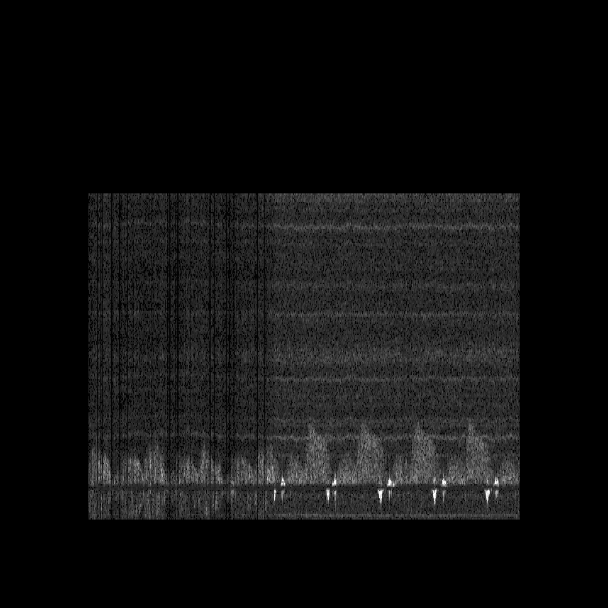

In [13]:
OUTPUT_H = 608
OUTPUT_W = 608

cropped, height, width = center_crop_or_pad_t(image, (OUTPUT_H, OUTPUT_W))

print(cropped.shape, cropped.dtype)

print(f'shifts: {height_shift}, {width_shift}')
render_torch_image(cropped)

torch.Size([1, 608, 608]) torch.float32


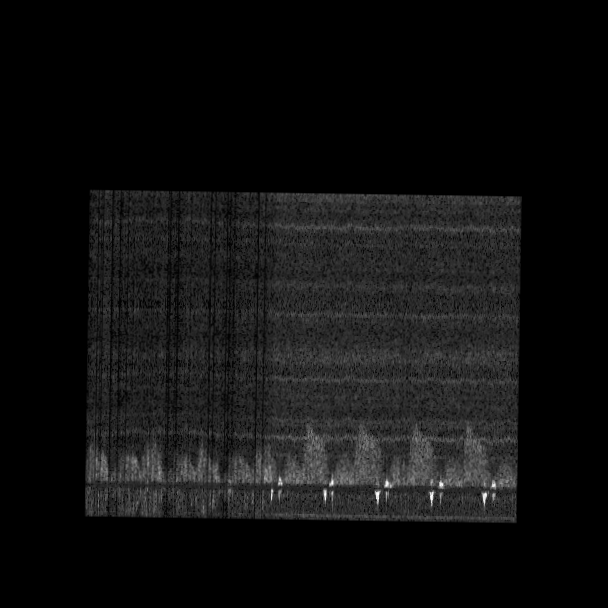

In [24]:
transform = random_transform_with_fixed_scaling(
    cropped, 
    translation_range=(-0.1, 0.1), 
    rotation_range=(-5, 5), 
    scale=(1.0, 1.0)
)

transformed = warp_perspective(cropped.to(torch.float32).unsqueeze(1), transform, dsize=(OUTPUT_H, OUTPUT_W)).squeeze(1)

print(transformed.shape, transformed.dtype)
render_torch_image(transformed)

In [26]:
heatmap_gen = UnityMakeHeatmaps(
    keypoint_names=['curve-flow'],
    image_crop_size=(OUTPUT_H, OUTPUT_W),
    image_out_size=(OUTPUT_H, OUTPUT_W),
)

heatmaps, weights = heatmap_gen.forward(
    label_data=[labels],
    label_height_shift=[height_shift],
    label_width_shift=[width_shift],
    transform_matrix=[transform],
)

/home/guilherme/scantensus-sdy/src/utils/matt_heatmap.py:553: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  gauss = render_gaussian_curve(mean=points, std=std, size=size)


/tmp/ipykernel_178372/2323000804.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet_map = cm.get_cmap('jet')


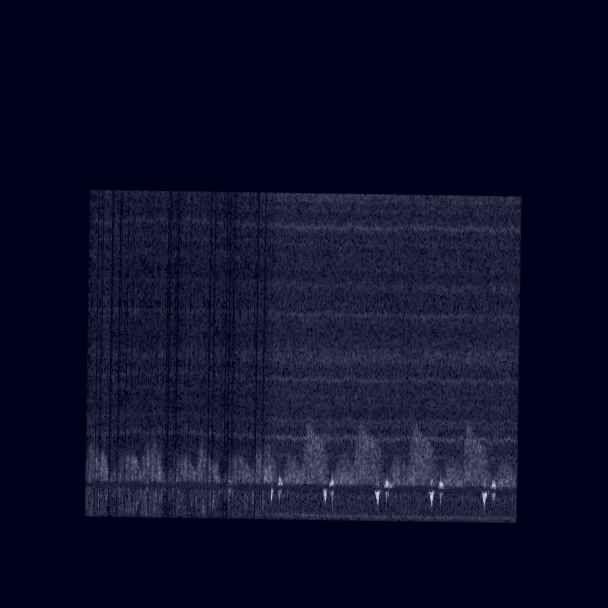

In [31]:
transformed_image = torchvision.transforms.ToPILImage()(transformed.to(torch.uint8).squeeze()).convert('RGBA')

heatmap = heatmaps[0].squeeze()
jet_map = cm.get_cmap('jet')

heatmap_jetted = PIL.Image.fromarray((jet_map(heatmap.numpy()) * 255).astype(np.uint8))
heatmap_jetted = heatmap_jetted.convert('RGBA').resize(transformed_image.size)

blended = PIL.Image.blend(transformed_image, heatmap_jetted, alpha=0.2)

blended